In [11]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:

import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools as nd
import math as m

In [13]:
instr = np.load('instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [14]:
nside = 64
freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)
print(freq_maps.shape)

(22, 3, 49152)


In [15]:
components= [CMB(), Dust(50.), Synchrotron(50.)]

In [16]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
#invN=np.linalg.inv(np.eye(len(instrument.frequency)))
invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)

In [17]:
x0 = np.array([1.3,19,-2.5])
x1 = np.array([1.3,19,-2.5, 0.8,1.3])
x2 =np.array([1.54, 20, -3, 1.1, 0.4, 1.5, 0.8, 1.2, 0.6, 0.3, 1.5, 0.5, 1.5, 1.2, 1.1, 0.8, 1.4, 0.7, 1.4, 0.4, 0.6, 0.8, 1.2, 1.5])  

406.03114070211393
0.049627263498797224


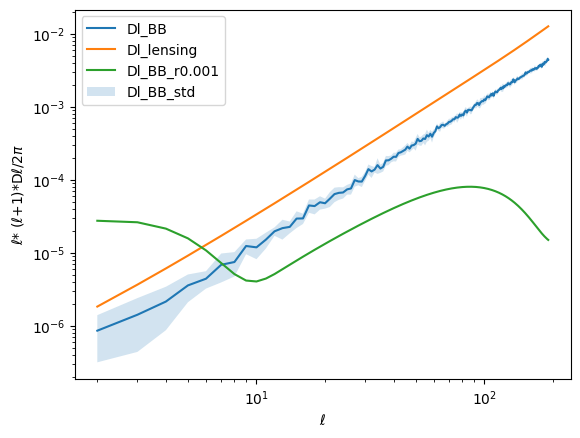

In [18]:
Cl_all = []
seeds = 10
for i in range (seeds):
    np.random.seed(i)
    #noise =np.random.random
    freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
    

    def spectral_likelihood(x):
        invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
        A_maxL =A_ev(x) 
        logL = 0
        AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
        AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
        logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
        if logL != logL:
            return 0.0
        return -logL

    min_= minimize (spectral_likelihood, x0, method='Nelder-Mead')
    # print(min_)
    # print(min_.x)
    
    
   
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =A_ev(min_.x) 
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    s = np.einsum('cg,gsp->csp', AtNA,AtNd)
    s = s[0]
    zeros=np.zeros((1, 49152))
    unione = np.vstack((zeros, s))
    
    
    Cl =hp.anafast(unione)[2,2:]
    Cl_all.append(Cl)
 
Cl_all=np.array(Cl_all)
Cl_mean=np.mean(Cl_all, axis=0) 
Cl_std = np.std(Cl_all, axis=0)



ell = np.arange(2,192)
Dl_mean = (ell*(ell+1)*Cl_mean)/(2*m.pi)
Dl_std = (ell*(ell+1)*Cl_std)/(2*m.pi)




Cl_BB = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

Data = Dl_mean + Dl_lens
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Dl_BB** 2 / Data ** 2)
sigma_r_fisher = np.sqrt(1.0 / F)
print(F)
print(sigma_r_fisher)





plt.loglog(ell, Dl_mean, label = "Dl_BB")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001")
plt.fill_between(ell,Dl_mean+Dl_std, Dl_mean-Dl_std, alpha=0.2, label="Dl_BB_std")



plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*D$\ell$/2$\pi$')
plt.legend()



    


392.57816459193447
0.05047042128512234


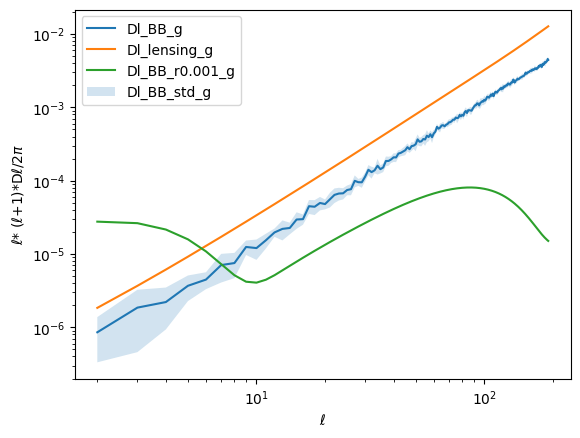

In [19]:
Cl_all_g = []
seeds = 10
for i in range (seeds):
    np.random.seed(i)
    #noise =np.random.random
    freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
    

    def spectral_likelihood(y):
        Bd, T, Bs, a, c = y
        b = 1
        G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])
        invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
        A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
        logL = 0
        AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
        AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
        logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
        if logL != logL:
            return 0.0
        return -logL

    min_= minimize (spectral_likelihood, x1, method='Nelder-Mead')
    # print(min_)
    #print(min_.x)
 
    
    a = min_.x[3]
    b= 1
    c = min_.x[4]
    G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])  
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(min_.x)) 

    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))


    s = np.einsum('cg,gsp->csp', AtNA,AtNd)
    s = s[0]
    zeros=np.zeros((1, 49152))
    unione = np.vstack((zeros, s))
    
    
    Cl =hp.anafast(unione)[2,2:]
    Cl_all_g.append(Cl)
 

Cl_all_g=np.array(Cl_all_g)
Cl_mean_g=np.mean(Cl_all_g, axis=0) 
Cl_std_g = np.std(Cl_all_g, axis=0)



ell = np.arange(2,192)
Dl_mean_g = (ell*(ell+1)*Cl_mean_g)/(2*m.pi)
Dl_std_g = (ell*(ell+1)*Cl_std_g)/(2*m.pi)




Cl_BB = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

Data_g = Dl_mean_g + Dl_lens
fsky = 1
F_g = np.sum((2*ell+1) * fsky / 2*Dl_BB** 2 / Data_g ** 2)
sigma_r_fisher_g = np.sqrt(1.0 / F_g)
print(F_g)
print(sigma_r_fisher_g)





plt.loglog(ell, Dl_mean_g, label = "Dl_BB_g")
plt.loglog(ell, Dl_lens, label = "Dl_lensing_g")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001_g")
plt.fill_between(ell,Dl_mean_g+Dl_std_g, Dl_mean_g-Dl_std_g, alpha=0.2, label="Dl_BB_std_g")



plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*D$\ell$/2$\pi$')
plt.legend()


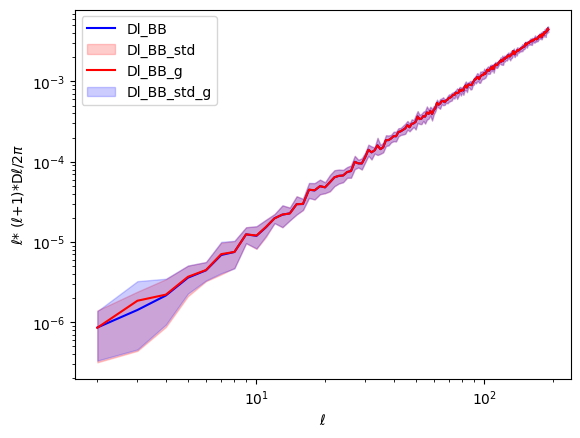

In [20]:
plt.loglog(ell, Dl_mean, label = "Dl_BB", color= 'blue')
plt.fill_between(ell,Dl_mean+Dl_std, Dl_mean-Dl_std, alpha=0.2, label="Dl_BB_std", color = 'red')
plt.loglog(ell,Dl_mean_g, label = "Dl_BB_g", color = 'red')
plt.fill_between(ell,Dl_mean_g+Dl_std_g, Dl_mean_g-Dl_std_g, alpha=0.2, label="Dl_BB_std_g", color = 'blue')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*D$\ell$/2$\pi$')
plt.legend()